In [1]:
import numpy as np
import torch
import pretty_midi as pm
import matplotlib.pyplot as plt
import os

import IPython.display     # IPython's display module (for in-line audio)

In [2]:
import numpy as np
import sklearn.metrics

def __convert_piano_roll_to_note_onset_duration(x):
    '''

    :param x: numpy, num_songs*num_frames(32)*MIDI_DIM(128) [0,1,2]={silence, sustain, onset}
    :return: numpy, num_songs*num_frames(32)*MIDI_DIM(128), value=duration if any onset otherwise 0
    '''
    num_songs=x.shape[0]
    num_frames=x.shape[1]
    midi_dim=x.shape[2]
    nk=int(np.floor(np.log2(num_frames-1)))+1
    duration_matrix=np.zeros_like(x,dtype=np.int64)
    duration_matrix[x==1]=1
    for log_d in range(nk):
        d=2**log_d
        shift_duration_matrix=np.zeros_like(duration_matrix,dtype=np.int64)
        shift_duration_matrix[:,:-d,:]=duration_matrix[:,d:,:]
        duration_matrix=(duration_matrix==d)*shift_duration_matrix+duration_matrix
    result=np.zeros_like(x,dtype=np.int64)
    result[:,:-1,:]=duration_matrix[:,1:,:]
    result[x==2]+=1
    result[x!=2]=0
    return result



def __note_level_reconstruction(original_x,recon_x):
    print('[NOTE-LEVEL RECONSTRUCTION]')
    original_notes=__convert_piano_roll_to_note_onset_duration(original_x)
    recon_notes=__convert_piano_roll_to_note_onset_duration(recon_x)
    num_positive=np.sum(recon_notes>0)
    num_true=np.sum(original_notes>0)
    tp_onset=np.sum(np.logical_and(recon_notes>0,original_notes>0))
    tp_offset=np.sum(np.logical_and(original_notes==recon_notes,original_notes>0))
    def report_binary_score(tp,name):
        p=tp/num_positive
        r=tp/num_true
        f1=2*p*r/(p+r)
        print('%s: \tP=%.4f,R=%.4f,F1=%.4f'%(name,p,r,f1))
    report_binary_score(tp_onset,'PITCH+ONSET')
    report_binary_score(tp_offset,'PITCH+ON+OFF')
    durations_recon=recon_notes[np.logical_and(recon_notes>0,original_notes>0)]
    durations_origin=original_notes[np.logical_and(recon_notes>0,original_notes>0)]
    durations_tp=np.minimum(durations_origin,durations_recon).sum()
    durations_p=durations_tp/np.sum(durations_recon)
    durations_r=durations_tp/np.sum(durations_origin)
    durations_f1=2*durations_p*durations_r/(durations_p+durations_r)
    print('%s: \tP=%.4f,R=%.4f,F1=%.4f'%('GUS DURATION',durations_p,durations_r,durations_f1))



def collect_statistics(original_x,recon_x,z_mu,z_logvar):
    '''
    Polyphonic VAE evaluator, version 2.0, by jjy
    :param original_x: numpy, num_songs*num_frames(32)*MIDI_DIM(128) [0,1,2]={silence, sustain, onset}
    :param recon_x: numpy, num_songs*num_frames(32)*MIDI_DIM(128) [0,1,2]={silence, sustain, onset}
    :param z_mu: numpy, num_songs*z_dim
    :param z_logvar: numpy, num_songs*z_dim
    '''
    def report_binary_score(p,r,f0,index,name):
        print('%s: \tP=%.4f,R=%.4f,F1=%.4f'%(name,p[index],r[index],f0[index]))
    def average_kld(z_mu,z_sigma):
        return (-0.5*np.mean(1+z_sigma-z_mu**2-np.exp(z_sigma)))
    original_x=np.array(original_x)
    recon_x=np.array(recon_x)
    z_mu=np.array(z_mu)
    z_logvar=np.array(z_logvar)
    flat_original_x=original_x.reshape((-1))
    flat_recon_x=recon_x.reshape((-1))
    p,r,f,_=sklearn.metrics.precision_recall_fscore_support(flat_original_x,flat_recon_x,labels=[0,1,2])
    __note_level_reconstruction(original_x,recon_x)
    print('[FRAME-LEVEL RECONSTRUCTION]')
    print('OVERALL ACC=%.4f'%((flat_original_x==flat_recon_x).sum()/len(flat_recon_x)))
    report_binary_score(p,r,f,0,'SILENCE')
    report_binary_score(p,r,f,1,'SUSTAIN')
    report_binary_score(p,r,f,2,'ONSET')
    print('[KLD]')
    print('Z_DIM=%d'%z_mu.shape[-1])
    print('AVERAGE KLD=%f'%average_kld(z_mu.reshape((-1)),z_logvar.reshape((-1))))


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
from model import VAE

# ptvae = VAE()

# ptvae.load_state_dict(torch.load('model_decoder.pt', map_location=device))
# ptvae.to(device)

from model_tr_full_ultra_plus import VAETR

ptvae = VAETR(device=device).to(device)

# ptvae.load_state_dict(torch.load('runs_my_decoder/run_2024-04-24_16-33-11_256_0.0002_6/model_tr_encoder/pgrid-epoch-model.pt', map_location=device))
# ptvae.load_state_dict(torch.load('runs_my_decoder/run_2024-04-26_16-55-41_256_0.001_10/model_tr_encoder/pgrid-epoch-model.pt', map_location=device))

ptvae.load_state_dict(torch.load('runs_my_decoder/run_2024-04-28_22-14-18_110_0.001_10/model_tr_encoder/pgrid-epoch-model.pt', map_location=device))

<All keys matched successfully>

In [5]:
pitch_outs, dur_outs, dist = ptvae(torch.rand(2, 128, 16, 8).long().to(device))

dist

Normal(loc: torch.Size([2, 1024]), scale: torch.Size([2, 1024]))

In [6]:
def pianotree_2_prmat(pianotree):
    prmat = np.zeros((pianotree.shape[0], 128))
    for t in range(pianotree.shape[0]):
        for n in range(1, pianotree.shape[1]):
            note = pianotree[t, n]
            if note[0] == 129:
                break
            pitch = note[0]
            dur = int(''.join([str(_) for _ in note[1:]]), 2) + 1
            prmat[t, pitch] = dur
    return prmat

In [7]:
def convert_piano_roll(piano_roll):
    # Get the number of timesteps and notes
    timesteps, notes = piano_roll.shape
    # Initialize the result array with zeros
    result = np.zeros_like(piano_roll)
    
    # Iterate through each note
    for note in range(notes):
        t = 0
        while t < timesteps:
            duration = int(piano_roll[t, note])  # Convert to integer to handle durations
            if duration > 0:
                # Mark the note as pressed (2) at the start
                result[t, note] = 2
                # Mark the note as sustained (1) for the duration
                for d in range(1, duration):
                    if t + d < timesteps:  # Ensure we don't go out of bounds
                        result[t + d, note] = 1
                t += duration  # Skip the duration to next possible note start
            else:
                t += 1  # Move to the next timestep
    
    return result

In [8]:
def pianotree_2_prmat_with_onset(pianotree):
    prmat = pianotree_2_prmat(pianotree)
    prmat_new = convert_piano_roll(prmat)
    return prmat_new, prmat

In [10]:
from dataset_128 import PolyphonicDataset
from torch.utils.data import DataLoader


# dataset_path = "pop909+mlpv_t32_fix1"
# val_path = os.path.join(dataset_path, 'pop909+mlpv_t32_val_fix1.npy')
dataset_path = "new_data"
val_path = os.path.join(dataset_path, 'pop909+mlpv_t128_val.npy')


val_dataset = PolyphonicDataset(val_path, 0, 0)
val_loader = DataLoader(val_dataset, 128, False)

print(len(val_loader))


174


In [11]:
all_val_data = []
all_val_data_prmat = []
i = 0
for x in val_loader:
    x = x.numpy()
    for y in x:
        prmat_new, prmat = pianotree_2_prmat_with_onset(y)
        all_val_data.append(prmat_new)
        all_val_data_prmat.append(prmat)

    i += 1
    if i == 100:
        break

all_val_data_orig = np.array(all_val_data)
all_val_data_orig.shape


(12800, 128, 128)

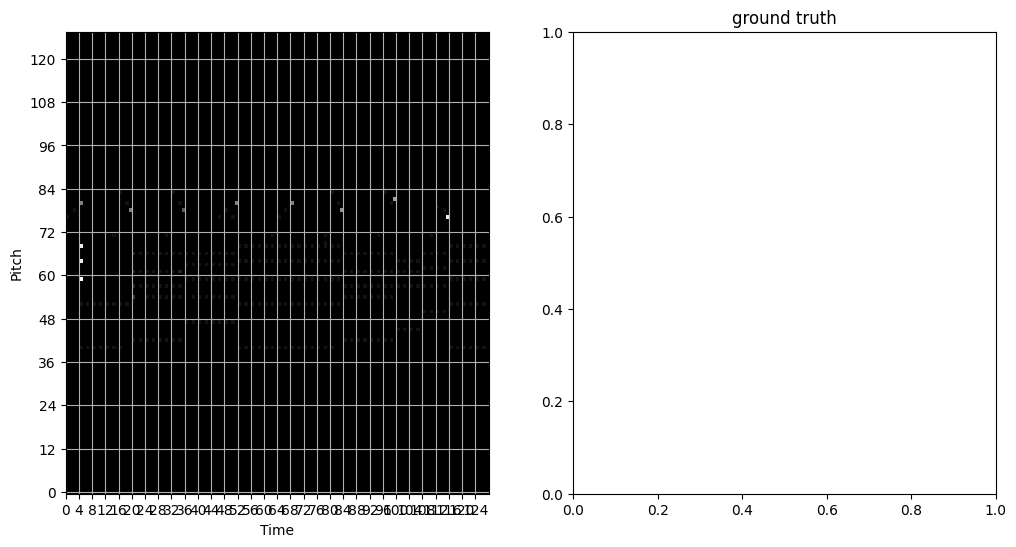

In [11]:
def plot_piano_roll(ax, pr, title, subdiv=4, xlabel='Time', ylabel='Pitch'):
    # assume input pr is (T, P).
    T, P = pr.shape
    ax.imshow(pr.T, origin='lower', aspect='auto', cmap='gray')
    
    ax.set_xticks(np.arange(0 - 0.5, T - 0.5, subdiv))
    ax.set_xticklabels(np.arange(0, T, subdiv))
    ax.set_xlabel(xlabel)
    ax.set_yticks(np.arange(0, P, 12))
    ax.set_ylabel(ylabel)
    
    plt.title(title)
    ax.grid()


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_piano_roll(ax[0], all_val_data_prmat[0], 'ground truth')

In [12]:

all_recon_data = []
i  = 0
ptvae.eval()

with torch.no_grad():
    for x in val_loader:
        pitch_outs, dur_outs, dist = ptvae(x.to(device), inference=True)
        est_pitch = pitch_outs.max(-1)[1].unsqueeze(-1)
        est_dur = dur_outs.max(-1)[1]
        recon = torch.cat([est_pitch, est_dur], dim=-1)
        sos_line = torch.zeros(recon.size(0), ptvae.num_step, 1, 8, dtype=recon.dtype, device=recon.device)
        sos_line[:, :, :, 0] = ptvae.pitch_sos
        sos_line[:, :, :, 1:] = ptvae.dur_pad
        recon = torch.cat([sos_line, recon], dim=2)
        recon = recon.cpu().numpy()
        for y in recon:
            prmat_new, _ = pianotree_2_prmat_with_onset(y)
            all_recon_data.append(prmat_new)

        i += 1
        if i == 100:
            break
    
    

/home/rikhat.akizhanov/Desktop/cources/ML711/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [13]:
all_recon_data = np.array(all_recon_data)
all_recon_data.shape

(12800, 128, 128)

In [14]:
collect_statistics(all_val_data_orig, all_recon_data, np.zeros((1, 16)), np.zeros((1, 16)))

[NOTE-LEVEL RECONSTRUCTION]
PITCH+ONSET: 	P=0.8194,R=0.8043,F1=0.8118
PITCH+ON+OFF: 	P=0.7026,R=0.6896,F1=0.6961
GUS DURATION: 	P=0.9487,R=0.9002,F1=0.9239
[FRAME-LEVEL RECONSTRUCTION]
OVERALL ACC=0.9879
SILENCE: 	P=0.9929,R=0.9948,F1=0.9938
SUSTAIN: 	P=0.7508,R=0.6719,F1=0.7091
ONSET: 	P=0.8194,R=0.8043,F1=0.8118
[KLD]
Z_DIM=16
AVERAGE KLD=-0.000000
